# Ayudantía 1 : Fisica Computacional III
### Profesor: Omar Fernández 
### Ayudante : Nicolás Campos



# 🧠 Introducción a los Métodos Numéricos

En física computacional, muchos problemas no tienen solución analítica exacta y debemos recurrir a métodos **numéricos** para obtener soluciones aproximadas.  
Estos métodos requieren:

- **Modelar** el problema (por ejemplo, con EDOs).
- **Discretizar** el tiempo o el espacio.
- **Elegir un método** adecuado según precisión, eficiencia y estabilidad.

---


# 🔢 Representación Binaria de Números en Python

Todo número en el computador se representa internamente en **binario**, usando estándares como IEEE-754 para números de punto flotante (`float`).

---

## 💡 ¿Por qué es importante conocer esta representación?

- Permite **comprender errores de redondeo** y límites de precisión.
- Explica comportamientos extraños como `0.1 + 0.2 ≠ 0.3`.
- Ayuda a identificar problemas de **cancelación numérica**.
- Es esencial para diseñar **algoritmos numéricamente estables**.

---

## 🧮 ¿Cómo funciona IEEE-754 (double precision, 64 bits)?

Cada número `float64` se representa con:

| Campo     | Bits | Descripción                           |
|-----------|------|----------------------------------------|
| Signo     | 1    | 0 = positivo, 1 = negativo              |
| Exponente | 11   | En base 2, con sesgo de 1023            |
| Mantisa   | 52   | Dígitos binarios fraccionarios (sin el 1 implícito) |

Por ejemplo, el número `0.1` en binario se ve así:




---

## 🔍 Comparación visual con decimal:

| Decimal     | Binario IEEE-754 aproximado               |
|-------------|--------------------------------------------|
| `0.1`       | `001111111011100110011001100110011001...`  |
| `1.0`       | `001111111111000000000000000000000000...`  |
| `-3.5`      | `110000000000110000000000000000000000...`  |

Usar esta estructura nos permite ver **cómo cambia cada bit** y cómo pequeños errores pueden propagarse en cálculos iterativos.


In [10]:
import struct

def float_to_ieee754(f):
    [d] = struct.unpack(">Q", struct.pack(">d", f))  # unsigned long long (64 bits)
    bits = f"{d:064b}"
    signo = bits[0]
    exponente = bits[1:12]
    mantisa = bits[12:]
    return signo, exponente, mantisa, bits

def mostrar_ieee754(f):
    signo, exponente, mantisa, bits = float_to_ieee754(f)
    print(f"Float: {f}")
    print(f"Signo     : {signo}")
    print(f"Exponente : {exponente} (decimal: {int(exponente, 2)} - bias 1023 = {int(exponente, 2) - 1023})")
    print(f"Mantisa   : {mantisa[:23]}...")
    print(f"Binario completo:\n{bits}")

# Prueba con 0.1
mostrar_ieee754(-123455.1234567890123456789)



Float: -123455.123456789
Signo     : 1
Exponente : 10000001111 (decimal: 1039 - bias 1023 = 16)
Mantisa   : 11100010001111110001111...
Binario completo:
1100000011111110001000111111000111111001101011011101001101110100



# 🔍 Análisis de Errores

### Tipos de error:

- **Error de redondeo:** por la representación finita.
- **Error de truncamiento:** al usar aproximaciones (por ejemplo, serie de Taylor finita).
- **Error absoluto vs. relativo:**

$$
\text{Error absoluto} = |x - \tilde{x}| \\
\text{Error relativo} = \frac{|x - \tilde{x}|}{|x|}
$$

### Ejemplo:

---


In [11]:
import numpy as np
true_val = np.exp(1)
approx_val = 1 + 1 + 1/2 + 1/6  # Taylor hasta x^3
abs_err = abs(true_val - approx_val)
rel_err = abs_err / abs(true_val)
print(f"Error absoluto: {abs_err:.5e}, relativo: {rel_err:.5e}")

Error absoluto: 5.16152e-02, relativo: 1.89882e-02


# 🧮 Serie de Taylor

La **Serie de Taylor** es una herramienta fundamental en métodos numéricos, ya que permite aproximar funciones suaves mediante **polinomios** alrededor de un punto \( x_0 \).

---

## 🔹 Definición general

La serie de Taylor de una función \( f(x) \) alrededor de un punto \( x_0 \) es:

\[
f(x) = f(x_0) + f'(x_0)(x - x_0) + \frac{f''(x_0)}{2!}(x - x_0)^2 + \cdots + \frac{f^{(n)}(x_0)}{n!}(x - x_0)^n + R_n(x)
\]

Donde:

- \( f^{(n)}(x_0) \): derivada n-ésima de \( f \) evaluada en \( x_0 \)
- \( R_n(x) \): término de error (residuo)

---

## 🛠️ Aplicaciones en Física Computacional

- Derivación de **métodos de integración numérica** (Euler, Verlet, RK).
- Estimación del **error local** de un método.
- Simulación de sistemas físicos con evolución temporal.

---

## 📉 Ejemplo práctico

Aproximar \( e^x \) usando los primeros términos de su serie alrededor de \( x_0 = 0 \):

\[
e^x \approx 1 + x + \frac{x^2}{2!} + \frac{x^3}{3!} + \cdots
\]

Para \( x = 0.5 \), esta aproximación converge muy rápidamente.

---

## 🧠 Interpretación Física

En simulaciones, usamos Taylor para expresar:

\[
x(t + \Delta t) \approx x(t) + v(t)\Delta t + \frac{1}{2}a(t)\Delta t^2 + \cdots
\]

¡Esta expansión da origen al **método de Verlet** y otros esquemas de integración!

---

## 📝 Observaciones

- Mientras más términos uses, **mejor la precisión**, pero también mayor el costo computacional.
- En métodos numéricos, **normalmente truncamos la serie** para balancear entre exactitud y eficiencia.


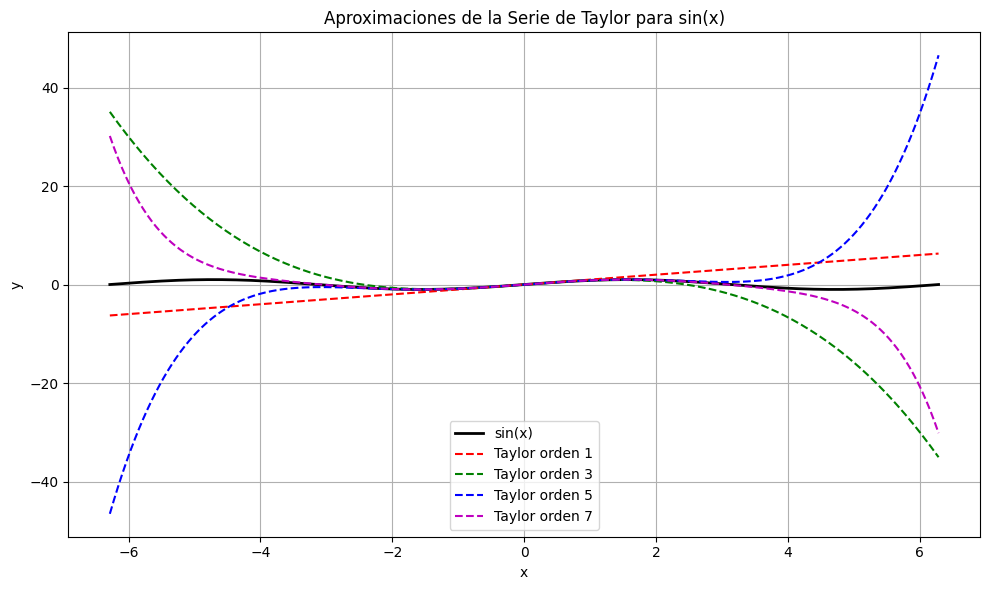

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math  # Importar el módulo correcto para factorial

# Función real
x = np.linspace(-2 * np.pi, 2 * np.pi, 400)
y = np.sin(x)

# Aproximación de Taylor para sin(x)
def taylor_sin(x, n_terms):
    approximation = np.zeros_like(x)
    for n in range(n_terms):
        coef = ((-1)**n) / math.factorial(2 * n + 1)
        approximation += coef * x**(2 * n + 1)
    return approximation

# Órdenes de aproximación
orders = [1, 3, 5, 7]
colors = ['r', 'g', 'b', 'm']

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='sin(x)', linewidth=2, color='black')

for order, color in zip(orders, colors):
    approx = taylor_sin(x, (order + 1) // 2)  # usa n_terms = (orden + 1) // 2
    plt.plot(x, approx, label=f'Taylor orden {order}', linestyle='--', color=color)

plt.title("Aproximaciones de la Serie de Taylor para sin(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


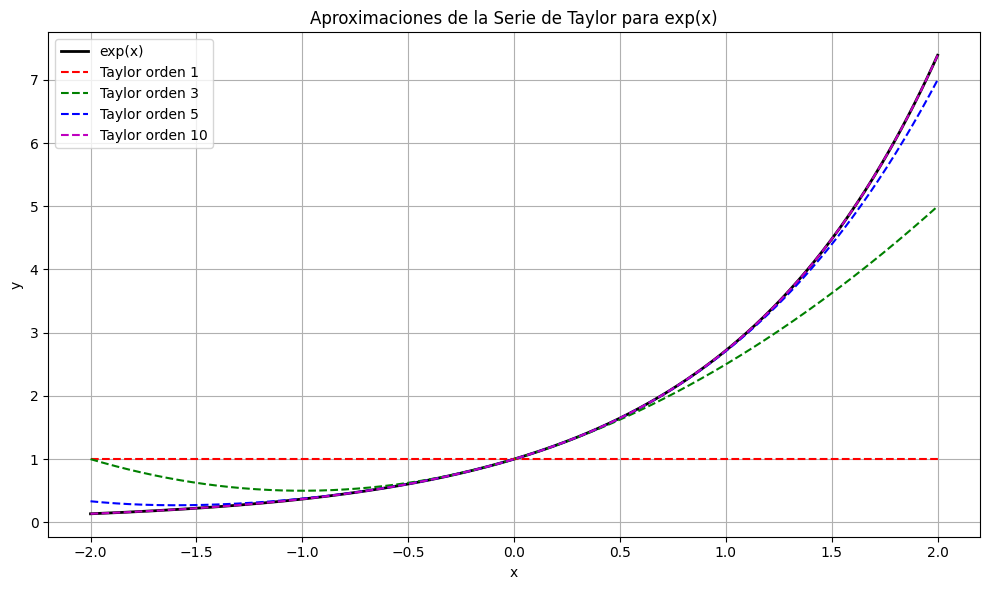

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Dominio
x = np.linspace(-2, 2, 400)
y = np.exp(x)

# Aproximación de Taylor para exp(x)
def taylor_exp(x, n_terms):
    approximation = np.zeros_like(x)
    for n in range(n_terms):
        approximation += x**n / math.factorial(n)
    return approximation

# Órdenes que queremos mostrar
orders = [1, 3, 5, 10]
colors = ['r', 'g', 'b', 'm']

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='exp(x)', linewidth=2, color='black')

for order, color in zip(orders, colors):
    approx = taylor_exp(x, order)
    plt.plot(x, approx, label=f'Taylor orden {order}', linestyle='--', color=color)

plt.title("Aproximaciones de la Serie de Taylor para exp(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


<div style="background-color: #FFF9AD; color: black; padding: 10px; border-radius: 5px;">

**Ejercicio 4:** Calcule las siguientes sumatorias que matemáticamente son equivalentes, considerando $N=10^0,10^1,10^2,…,10^5$. Grafique en una misma figura, las tendencias $S_1$ vs $N$ y $S_2$  vs $N$. ¿Para qué valor de $N$, $S_1$ y $S_2$ presentan la menor diferencia?

\begin{align*}

S_1 & = \sum_{i=1}^{N} \frac{2i}{2i+1} - \sum_{i=1}^{N} \frac{2i-1}{2i} \\

S_2 & = \sum_{i=1}^{N} \frac{1}{2i(2i+1)}

\end{align*}    

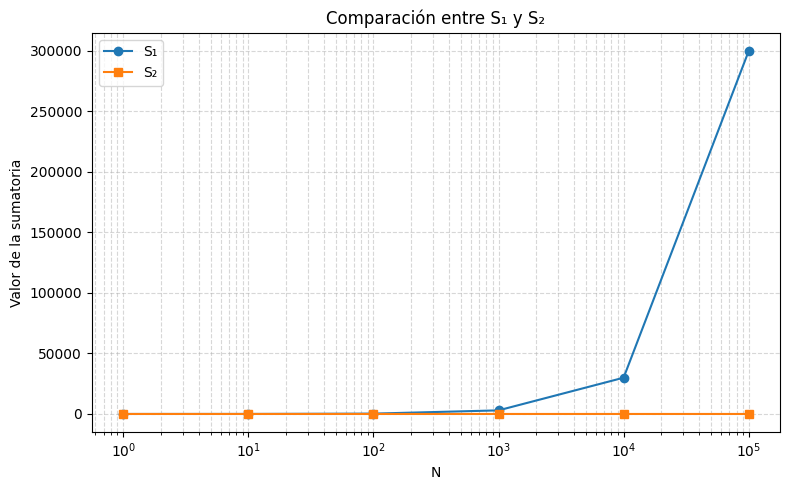

(np.int64(1), np.float64(1.8333333333333333))

In [14]:
import numpy as np
import matplotlib.pyplot as plt

Ns = np.logspace(0, 5, num=6, dtype=int)
S1_vals, S2_vals = [], []

for N in Ns:
   i = np.arange(1, N + 1)
   S1= np.sum(2+i/(2+i+1))-np.sum((1/(2+i-1)/2*1))
   S2= np.sum(1/(2*i*(2*i+1)))
   S1_vals.append(S1)
   S2_vals.append(S2)

S1_vals = np.array(S1_vals)
S2_vals = np.array(S2_vals)
# Diferencias
difference = np.abs(S1_vals - S2_vals)
min_diff_index = np.argmin(difference)
# Valor mínimo de la diferencia
min_diff_N = Ns[min_diff_index]

# Gráfico S1 vs S2
plt.figure(figsize=(8, 5))
plt.plot(Ns, S1_vals, label='S₁', marker='o')
plt.plot(Ns, S2_vals, label='S₂', marker='s')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('Valor de la sumatoria')
plt.title('Comparación entre S₁ y S₂')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

min_diff_N, difference[min_diff_index]

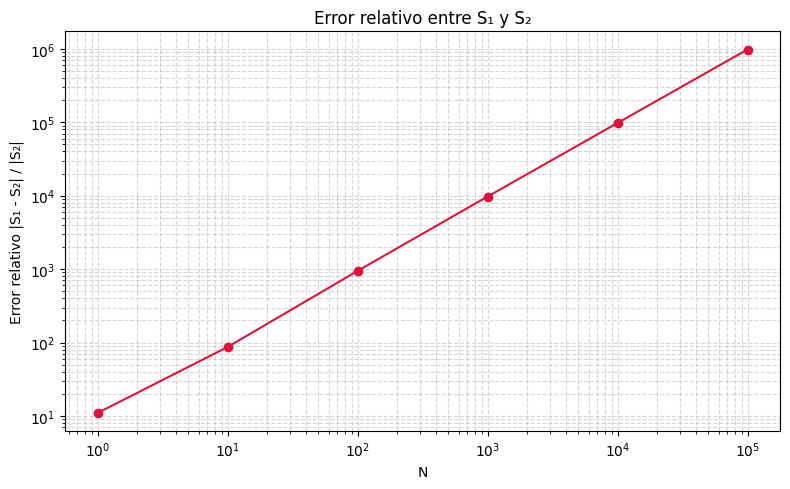

[(np.int64(1), np.float64(11.0)),
 (np.int64(10), np.float64(86.97186177987152)),
 (np.int64(100), np.float64(944.3941617690152)),
 (np.int64(1000), np.float64(9717.728467142633)),
 (np.int64(10000), np.float64(97681.6100730144)),
 (np.int64(100000), np.float64(977556.0216860025))]

In [6]:
# Error relativo
relative_error = np.abs((S1_vals - S2_vals) / S2_vals)

plt.figure(figsize=(8, 5))
plt.plot(Ns, relative_error, marker='o', color='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
plt.ylabel('Error relativo |S₁ - S₂| / |S₂|')
plt.title('Error relativo entre S₁ y S₂')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

list(zip(Ns, relative_error))

Esto es un ejemplo clásico de cómo dos expresiones matemáticamente equivalentes pueden tener comportamientos numéricos distintos debido a acumulación de errores de redondeo.

## 🧪 Ejercicio Propuesto – Cancelación numérica con raíces cuadradas

**Considere la función:**

$$
f(x) = \sqrt{x^2 + 1} - 1
$$

**a)** Evalúe $f(x)$ directamente para $x = 10^{-1}, 10^{-2}, \dots, 10^{-15}$.

**b)** Reescriba la función como:

$$
f(x) = \frac{x^2}{\sqrt{x^2 + 1} + 1}
$$

**c)** Compare ambas formas gráficamente y calcule el error relativo.


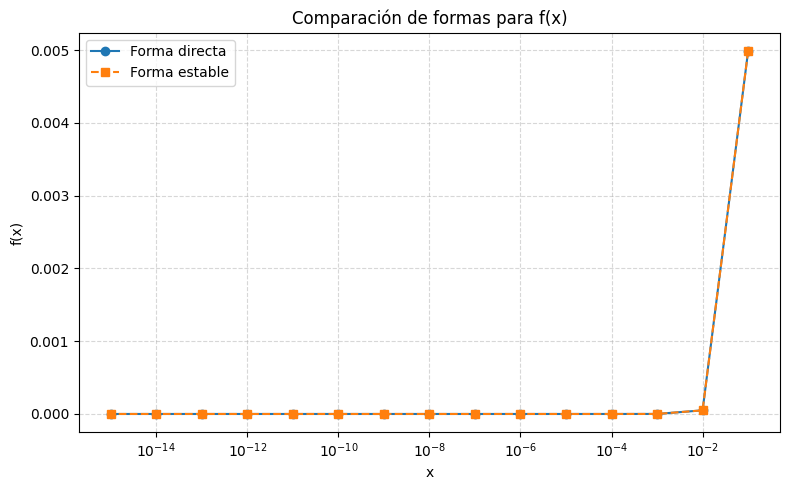

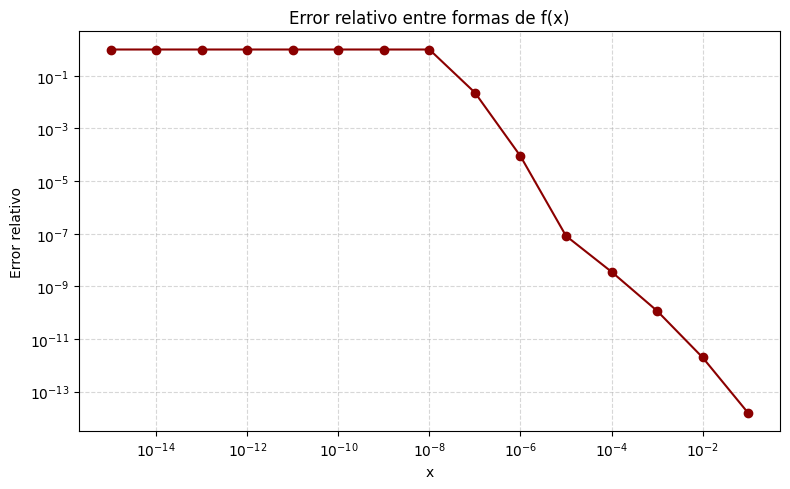

In [7]:
x_vals = 10.0**(-np.arange(1, 16))

f_direct = np.sqrt(x_vals**2 + 1) - 1
f_algebraic = x_vals**2 / (np.sqrt(x_vals**2 + 1) + 1)
rel_error = np.abs((f_direct - f_algebraic) / f_algebraic)

# Gráfica de ambas versiones
plt.figure(figsize=(8, 5))
plt.plot(x_vals, f_direct, 'o-', label='Forma directa')
plt.plot(x_vals, f_algebraic, 's--', label='Forma estable')
plt.xscale('log')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Comparación de formas para f(x)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico del error relativo
plt.figure(figsize=(8, 5))
plt.plot(x_vals, rel_error, 'o-', color='darkred')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('Error relativo')
plt.title('Error relativo entre formas de f(x)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()